# Apply Naive Bayes on `Donors Choose` dataset

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When using RandomSearchCV or GridSearchCV we need not split the data into X_train,X_cv,X_test. As the above methods use k-fold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for-loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='blue'>Set 1</font>: categorical, numerical features + preprocessed_essay (BOW)</li>
            <li><font color='blue'>Set 2</font>: categorical, numerical features + preprocessed_essay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

### Importing all the required libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve

In [2]:
import re

import os
from tqdm import tqdm
import pickle

In [3]:
# https://www.geeksforgeeks.org/creating-tables-with-prettytable-library-python/

!pip install PrettyTable

## 1.1 Loading Data

In [4]:
data = pd.read_csv('preprocessed_data.csv', nrows = 50000)
column_names = data.columns
print(column_names)

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')


In [5]:
# Have a sneak-peek into the dataset

data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [6]:
positive_datapoints = data[data['project_is_approved'] == 1]
print(positive_datapoints.shape)

(41993, 9)


In [7]:
negative_datapoints = data[data['project_is_approved'] == 0]
print(negative_datapoints.shape)

(8007, 9)


Since this is an imbalanced dataset, increase the count of negative datapoints using the upsampling/downsampling techniques. Here we used the <b>upsampling</b> technique.

In [8]:
from sklearn.utils import resample
upsampled_negative = resample(negative_datapoints, n_samples = 41993, replace = True, random_state = 42)

In [9]:
print(upsampled_negative.shape)

(41993, 9)


In [10]:
modified_dataset = pd.concat([positive_datapoints, upsampled_negative])
print(modified_dataset.shape)

(83986, 9)


In [11]:
y = modified_dataset['project_is_approved'].values
X = modified_dataset.drop(['project_is_approved'], axis = 1)
X.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [12]:
print(X.shape)
print(y.shape)

(83986, 8)
(83986,)


## 1.2 Splitting data into Train and cross validation(or test): Stratified Sampling

Whenever we want to perform simple cross-validation, we need to split the dataset into the train, CV and the test sets. If we want to perform K-fold CV(using 'for' loops) or GridSearch cross-validation or RandomSearch cross-validation, just split the dataset into the train and the test sets. The CV set gets created internally during the cross-validation. Even if we create a separate CV set while splitting the whole dataset, it goes waste without any usage. Hence, commented out the code lines where we have CV splitting & computation on the dataset.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.33, stratify = y_train)

In [14]:
# Check the number of datapoints in each set after data splits
print("# of points in Train Dataset: ",X_train.shape, y_train.shape)
print("# of points in Test Dataset: ",X_test.shape, y_test.shape)
# print("# of points in CV Dataset: ",X_cv.shape, y_cv.shape)

# of points in Train Dataset:  (56270, 8) (56270,)
# of points in Test Dataset:  (27716, 8) (27716,)


## 1.3 Make Data Model Ready: encoding `essay`
### 1.3.1 Set 1: Encoding `essay` using BoW Vectorization

In [15]:
vectorizer = CountVectorizer(min_df = 10, ngram_range = (1, 4), max_features = 50000)
vectorizer.fit(X_train['essay'].values)    # fit has to happen only on the train dataset ALWAYS

# Use fitted CountVectorizer to convert text into vector 
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)
# X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)

print("After vectorization")
print()
print('Train_essay_bow shape: ', X_train_essay_bow.shape, y_train.shape)
print('Test_essay_bow shape: ', X_test_essay_bow.shape, y_test.shape)
# print('CV_essay_bow shape: ', X_cv_essay_bow.shape, y_cv.shape)

essay_bow_features = vectorizer.get_feature_names()
print()
print('some `essay` BoW feature names: ', essay_bow_features[10000:10015])
print()
print('The total number of features:', len(essay_bow_features))

After vectorization

Train_essay_bow shape:  (56270, 50000) (56270,)
Test_essay_bow shape:  (27716, 50000) (27716,)

some `essay` BoW feature names:  ['desk students', 'desk table', 'desk the', 'desk this', 'desk top', 'desk work', 'desk would', 'desks', 'desks allow', 'desks allow students', 'desks chairs', 'desks classroom', 'desks day', 'desks give', 'desks hard']

The total number of features: 50000


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

### 1.4.1 Encoding `CATEGORICAL` features 

<h4> Perform <i>ONE-HOT ENCODING</i></h4>

#### 1.4.1.1 encoding categorical feature: `school_state`

In [16]:
vectorizer = CountVectorizer()
# vectorizer.fit(X_train['school_state'].values)    # ALWAYS fit on the train dataset only

# Use fit_transform on the train dataset directly
X_train_school_state_ohe = vectorizer.fit_transform(X_train['school_state'].values) 

# Use fitted CountVectorizer to convert text into vector 
X_test_school_state_ohe = vectorizer.transform(X_test['school_state'].values)
# X_cv_school_state_ohe = vectorizer.transform(X_cv['school_state'].values)

print("After vectorization")
print()
print('Train_school_state shape: ', X_train_school_state_ohe.shape, y_train.shape)
print('Test_school_state shape: ', X_test_school_state_ohe.shape, y_test.shape)
# print('CV_school_state shape: ', X_cv_school_state_ohe.shape, y_cv.shape)

school_state_features = vectorizer.get_feature_names()
print()
print('school_state feature names: ', school_state_features)
print()
print('The total number of features:', len(school_state_features))

After vectorization

Train_school_state shape:  (56270, 51) (56270,)
Test_school_state shape:  (27716, 51) (27716,)

school_state feature names:  ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

The total number of features: 51


#### 1.4.1.2 encoding categorical feature: `teacher_prefix`

In [17]:
vectorizer = CountVectorizer()
# vectorizer.fit(X_train['teacher_prefix'].values)    # ALWAYS fit on the train dataset only

# Use fit_transform on the train dataset directly
X_train_teacher_prefix_ohe = vectorizer.fit_transform(X_train['teacher_prefix'].values) 

# Use fitted CountVectorizer to convert text into vector 
X_test_teacher_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)
# X_cv_teacher_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)

print("After vectorization")
print()
print('Train_teacher_prefix shape: ', X_train_teacher_prefix_ohe.shape, y_train.shape)
print('Test_teacher_prefix shape: ', X_test_teacher_prefix_ohe.shape, y_test.shape)
# print('CV_teacher_prefix shape: ', X_cv_teacher_prefix_ohe.shape, y_cv.shape)

teacher_prefix_features = vectorizer.get_feature_names()
print()
print('teacher_prefix feature names: ', teacher_prefix_features)
print()
print('The total number of features:', len(teacher_prefix_features))

After vectorization

Train_teacher_prefix shape:  (56270, 5) (56270,)
Test_teacher_prefix shape:  (27716, 5) (27716,)

teacher_prefix feature names:  ['dr', 'mr', 'mrs', 'ms', 'teacher']

The total number of features: 5


#### 1.4.1.3 encoding categorical feature: `project_grade_category`

In [18]:
vectorizer = CountVectorizer()
# vectorizer.fit(X_train['project_grade_category'].values)    # ALWAYS fit on the train dataset only

# Use fit_transform on the train dataset directly
X_train_project_grade_category_ohe = vectorizer.fit_transform(X_train['project_grade_category'].values) 

# Use fitted CountVectorizer to convert text into vector 
X_test_project_grade_category_ohe = vectorizer.transform(X_test['project_grade_category'].values)
# X_cv_project_grade_category_ohe = vectorizer.transform(X_cv['project_grade_category'].values)

print("After vectorization")
print()
print('Train_project_grade_category shape: ', X_train_project_grade_category_ohe.shape, y_train.shape)
print('Test_project_grade_category shape: ', X_test_project_grade_category_ohe.shape, y_test.shape)
# print('CV_project_grade_category shape: ', X_cv_project_grade_category_ohe.shape, y_cv.shape)

project_grade_category_features = vectorizer.get_feature_names()
print()
print('project_grade_category feature names: ', project_grade_category_features)
print()
print('The total number of features:', len(project_grade_category_features))

After vectorization

Train_project_grade_category shape:  (56270, 4) (56270,)
Test_project_grade_category shape:  (27716, 4) (27716,)

project_grade_category feature names:  ['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']

The total number of features: 4


#### 1.4.1.4 encoding categorical feature: `clean_categories`

In [19]:
vectorizer = CountVectorizer()
# vectorizer.fit(X_train['clean_categories'].values)    # ALWAYS fit on the train dataset ONLY

# Use fit_transform on the train dataset directly
X_train_clean_categories_ohe = vectorizer.fit_transform(X_train['clean_categories'].values) 

# Use fitted CountVectorizer to convert text into vector 
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)
# X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)

print("After vectorization")
print()
print('Train_clean_categories shape: ', X_train_clean_categories_ohe.shape, y_train.shape)
print('Test_clean_categories shape: ', X_test_clean_categories_ohe.shape, y_test.shape)
# print('CV_clean_categories shape: ', X_cv_clean_categories_ohe.shape, y_cv.shape)

clean_categories_features = vectorizer.get_feature_names()
print()
print('clean_categories feature names: ', clean_categories_features)
print()
print('The total number of features:', len(clean_categories_features))

After vectorization

Train_clean_categories shape:  (56270, 9) (56270,)
Test_clean_categories shape:  (27716, 9) (27716,)

clean_categories feature names:  ['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']

The total number of features: 9


#### 1.4.1.5 encoding categorical feature: `clean_subcategories`

In [20]:
vectorizer = CountVectorizer()
# vectorizer.fit(X_train['clean_subcategories'].values)    # ALWAYS fit on the train dataset only

# Use fit_transform on the train dataset directly
X_train_clean_subcategories_ohe = vectorizer.fit_transform(X_train['clean_subcategories'].values) 

# Use fitted CountVectorizer to convert text into vector 
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)
# X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)

print("After vectorization")
print()
print('Train_clean_subcategories shape: ', X_train_clean_subcategories_ohe.shape, y_train.shape)
print('Test_clean_subcategories shape: ', X_test_clean_subcategories_ohe.shape, y_test.shape)
# print('CV_clean_subcategories shape: ', X_cv_clean_subcategories_ohe.shape, y_cv.shape)

clean_subcategories_features = vectorizer.get_feature_names()
print()
print('clean_subcategories feature names: ', clean_subcategories_features)
print()
print('The total number of features:', len(clean_subcategories_features))

After vectorization

Train_clean_subcategories shape:  (56270, 30) (56270,)
Test_clean_subcategories shape:  (27716, 30) (27716,)

clean_subcategories feature names:  ['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']

The total number of features: 30


### 1.4.2 Encoding `NUMERICAL` features

#### 1.4.2.1 encoding numerical feature: `price`

In [21]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

# Use fit_transform on the train dataset directly
X_train_price_norm = normalizer.fit_transform(X_train['price'].values.reshape(1, -1))

# Use fitted Normalizer to normalize the values 
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1, -1))
# X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1, -1))

print("After vectorization")
print()
print('Train_price shape: ', X_train_price_norm.shape, y_train.shape)
print('Test_price shape: ', X_test_price_norm.shape, y_test.shape)
# print('CV_price shape: ', X_cv_price_norm.shape, y_cv.shape)

After vectorization

Train_price shape:  (1, 56270) (56270,)
Test_price shape:  (1, 27716) (27716,)


#### 1.4.2.2 encoding numerical feature: `teacher_number_of_previously_posted_projects`

In [22]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

# Use fit_transform on the train dataset directly
X_train_teacher_number_of_previously_posted_projects_norm = normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))

# Use fitted Normalizer to normalize the values 
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))
# X_cv_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))

print("After vectorization")
print()
print('Train_price shape: ', X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print('Test_price shape: ', X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
# print('CV_price shape: ', X_cv_teacher_number_of_previously_posted_projects_norm.shape, y_cv.shape)

After vectorization

Train_price shape:  (1, 56270) (56270,)
Test_price shape:  (1, 27716) (27716,)


<h3> Concatenating all BoW <i>tranformed features</i> </h3>

In [23]:
X_train_price_norm = X_train_price_norm.reshape(56270, 1)
X_test_price_norm = X_test_price_norm.reshape(27716, 1)
# X_cv_price_norm = X_cv_price_norm.reshape(11055, 1)

X_train_teacher_number_of_previously_posted_projects_norm = X_train_teacher_number_of_previously_posted_projects_norm.reshape(56270, 1)
X_test_teacher_number_of_previously_posted_projects_norm = X_test_teacher_number_of_previously_posted_projects_norm.reshape(27716, 1)
# X_cv_teacher_number_of_previously_posted_projects_norm = X_cv_teacher_number_of_previously_posted_projects_norm.reshape(11055, 1)

from scipy.sparse import hstack

X_Train_set1 = hstack((X_train_essay_bow, X_train_school_state_ohe, X_train_teacher_prefix_ohe, 
                  X_train_project_grade_category_ohe, 
                  X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_price_norm, 
                  X_train_teacher_number_of_previously_posted_projects_norm)).tocsr()

X_Test_set1 = hstack((X_test_essay_bow, X_test_school_state_ohe, X_test_teacher_prefix_ohe, 
                  X_test_project_grade_category_ohe, 
                  X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_price_norm, 
                  X_test_teacher_number_of_previously_posted_projects_norm)).tocsr()

# X_CV_set1 = hstack((X_cv_essay_bow, X_cv_school_state_ohe, X_cv_teacher_prefix_ohe, 
#                   X_cv_project_grade_category_ohe, 
#                   X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_price_norm, 
#                   X_cv_teacher_number_of_previously_posted_projects_norm)).tocsr()

print("Final matrix:")
print()
print(X_Train_set1.shape, y_train.shape)
# print(X_CV_set1.shape, y_cv.shape)
print(X_Test_set1.shape, y_test.shape)

Final matrix:

(56270, 50101) (56270,)
(27716, 50101) (27716,)


### 1.3.2 Set 2: Encoding `essay` using TFIDF Vectorization

In [24]:
vector = TfidfVectorizer(min_df = 10, ngram_range = (1, 4), max_features = 50000)
vector.fit(X_train['essay'].values)    # ALWAYS fit has to happen only on the train dataset only

# Use fitted TFIDF Vectorizer to convert text into vector 
X_train_essay_tfidf = vector.transform(X_train['essay'].values)
X_test_essay_tfidf = vector.transform(X_test['essay'].values)
# X_cv_essay_tfidf = vector.transform(X_cv['essay'].values)

print("After Vectorization")
print('Train_essay_tfidf shape: ', X_train_essay_tfidf.shape, y_train.shape)
print('Test_essay_tfidf shape: ', X_test_essay_tfidf.shape, y_test.shape)
# print('CV_essay_tfidf shape: ', X_cv_essay_tfidf.shape, y_cv.shape)

print()
essay_tfidf_features = vector.get_feature_names()
print("some TFIDF `essay` feature names: ", essay_tfidf_features[10000:10015])
print()
print('The total number of features:', len(essay_tfidf_features))

After Vectorization
Train_essay_tfidf shape:  (56270, 50000) (56270,)
Test_essay_tfidf shape:  (27716, 50000) (27716,)

some TFIDF `essay` feature names:  ['desk students', 'desk table', 'desk the', 'desk this', 'desk top', 'desk work', 'desk would', 'desks', 'desks allow', 'desks allow students', 'desks chairs', 'desks classroom', 'desks day', 'desks give', 'desks hard']

The total number of features: 50000


<h3> Concatenating all TFIDF <i>tranformed features</i> </h3>

In [25]:
X_train_price_norm = X_train_price_norm.reshape(56270, 1)
X_test_price_norm = X_test_price_norm.reshape(27716, 1)
# X_cv_price_norm = X_cv_price_norm.reshape(11055, 1)

X_train_teacher_number_of_previously_posted_projects_norm = X_train_teacher_number_of_previously_posted_projects_norm.reshape(56270, 1)
X_test_teacher_number_of_previously_posted_projects_norm = X_test_teacher_number_of_previously_posted_projects_norm.reshape(27716, 1)
# X_cv_teacher_number_of_previously_posted_projects_norm = X_cv_teacher_number_of_previously_posted_projects_norm.reshape(11055, 1)

from scipy.sparse import hstack

X_Train_set2 = hstack((X_train_essay_tfidf, X_train_school_state_ohe, X_train_teacher_prefix_ohe, 
                  X_train_project_grade_category_ohe, 
                  X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_price_norm, 
                  X_train_teacher_number_of_previously_posted_projects_norm)).tocsr()

X_Test_set2 = hstack((X_test_essay_tfidf, X_test_school_state_ohe, X_test_teacher_prefix_ohe, 
                  X_test_project_grade_category_ohe, 
                  X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_price_norm, 
                  X_test_teacher_number_of_previously_posted_projects_norm)).tocsr()

# X_CV_set2 = hstack((X_cv_essay_tfidf, X_cv_school_state_ohe, X_cv_teacher_prefix_ohe, 
#                   X_cv_project_grade_category_ohe, 
#                   X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_price_norm, 
#                   X_cv_teacher_number_of_previously_posted_projects_norm)).tocsr()

print("Final matrix:")
print()
print(X_Train_set2.shape, y_train.shape)
# print(X_CV_set2.shape, y_cv.shape)
print(X_Test_set2.shape, y_test.shape)

Final matrix:

(56270, 50101) (56270,)
(27716, 50101) (27716,)


## 1.5 Appling Naive Bayes on different kind of featurization 
<br> Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instructions

#### Whenever the training dataset is highly imbalanced, we can make the initializations fit_prior = False, class_prior = [0.5, 0.5] in MultinomialNB(). 

### 1.5.1 Applying Multinomial Naive Bayes on `feature set 1`

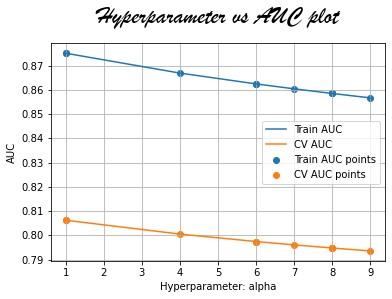

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,0.135270,0.009687,0.044901,0.006359,1,{'alpha': 1},0.800846,0.811620,0.806203,0.806223,0.004398,1,0.877868,0.874231,0.873167,0.875089,0.002013
7,0.155284,0.015573,0.068101,0.013314,1,{'alpha': 1},0.800846,0.811620,0.806203,0.806223,0.004398,1,0.877868,0.874231,0.873167,0.875089,0.002013
4,0.141659,0.015621,0.044575,0.005954,4,{'alpha': 4},0.795064,0.806019,0.800441,0.800508,0.004473,3,0.869752,0.865985,0.864977,0.866905,0.002055
5,0.160488,0.014384,0.073891,0.043565,6,{'alpha': 6},0.791974,0.802976,0.797387,0.797446,0.004492,4,0.865335,0.861472,0.860522,0.862443,0.002081
9,0.137020,0.026541,0.046539,0.008387,6,{'alpha': 6},0.791974,0.802976,0.797387,0.797446,0.004492,4,0.865335,0.861472,0.860522,0.862443,0.002081


In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

model = MultinomialNB()
parameters = {'alpha': sp_randint(0.1, 10)}
clf1 = RandomizedSearchCV(estimator = model, param_distributions = parameters, cv = 3, scoring = 'roc_auc', 
                         return_train_score = True)
clf1.fit(X_Train_set1, y_train)

results = pd.DataFrame.from_dict(clf1.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std = results['std_test_score']
alpha =  results['param_alpha']

plt.plot(alpha, train_auc, label = 'Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc, label = 'CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_auc, label = 'Train AUC points')
plt.scatter(alpha, cv_auc, label = 'CV AUC points')


plt.legend()
plt.xlabel("Hyperparameter: alpha")
plt.ylabel("AUC")
plt.title("Hyperparameter vs AUC plot", fontname = "Brush Script MT", fontsize = 25, pad = 20)
plt.grid()
plt.show()

results.head()

In [27]:
best_alpha_set1 = clf1.best_estimator_
print("Best alpha:", best_alpha_set1.alpha)

Best alpha: 1


### 1.5.2 Applying Multinomial Naive Bayes on `feature set 2`

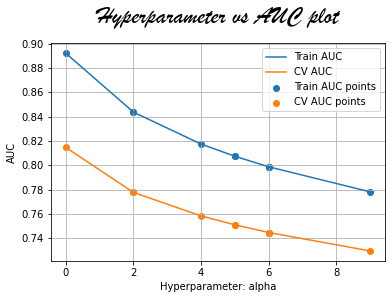

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,0.162127,0.027226,0.049797,0.011901,0,{'alpha': 0},0.811502,0.818151,0.814567,0.814740,0.002717,1,0.894528,0.891101,0.890690,0.892107,0.001721
3,0.137770,0.011926,0.058395,0.004602,2,{'alpha': 2},0.775543,0.780816,0.776999,0.777786,0.002223,2,0.847045,0.842532,0.841667,0.843748,0.002358
5,0.181635,0.021968,0.063992,0.015407,2,{'alpha': 2},0.775543,0.780816,0.776999,0.777786,0.002223,2,0.847045,0.842532,0.841667,0.843748,0.002358
7,0.161617,0.034119,0.053766,0.014286,4,{'alpha': 4},0.756660,0.761099,0.757669,0.758476,0.001900,4,0.821030,0.816286,0.815186,0.817501,0.002536
0,0.156895,0.019420,0.059194,0.006846,5,{'alpha': 5},0.749534,0.753631,0.750362,0.751176,0.001769,5,0.811087,0.806316,0.805125,0.807510,0.002576


In [28]:
model = MultinomialNB()
parameters = {'alpha': sp_randint(0.1, 10)}
clf2 = RandomizedSearchCV(estimator = model, param_distributions = parameters, cv = 3, scoring = 'roc_auc', 
                         return_train_score = True)
clf2.fit(X_Train_set2, y_train)

results = pd.DataFrame.from_dict(clf2.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std = results['std_test_score']
alpha =  results['param_alpha']

plt.plot(alpha, train_auc, label = 'Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc, label = 'CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_auc, label = 'Train AUC points')
plt.scatter(alpha, cv_auc, label = 'CV AUC points')


plt.legend()
plt.xlabel("Hyperparameter: alpha")
plt.ylabel("AUC")
plt.title("Hyperparameter vs AUC plot", fontname = "Brush Script MT", fontsize = 25, pad = 20)
plt.grid()
plt.show()

results.head()

In [29]:
best_alpha_set2 = clf2.best_estimator_
print("Best alpha:", best_alpha_set2.alpha)

Best alpha: 0


### 1.6 Train Model using the best Hyperparameters

#### 1.6.1 For `feature set 1` 

In [30]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

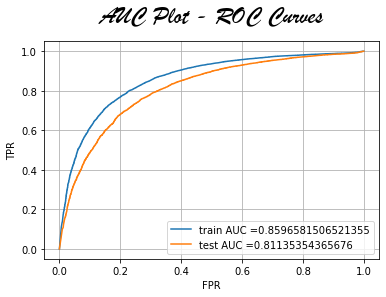

In [31]:
clf_set1 = MultinomialNB(best_alpha_set1.alpha)
clf_set1.fit(X_Train_set1, y_train)

y_train_pred1 = batch_predict(clf_set1, X_Train_set1)    
y_test_pred1 = batch_predict(clf_set1, X_Test_set1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred1)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred1)

auc_set1 = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Plot - ROC Curves", fontname = "Brush Script MT", fontsize = 25, pad = 20)
plt.grid()
plt.show()

#### 1.6.2 For `feature set 2` 

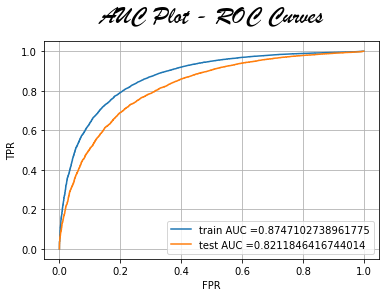

In [32]:
clf_set2 = MultinomialNB(best_alpha_set2.alpha)
clf_set2.fit(X_Train_set2, y_train)

y_train_pred2 = batch_predict(clf_set2, X_Train_set2)    
y_test_pred2 = batch_predict(clf_set2, X_Test_set2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred2)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred2)

auc_set2 = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC Plot - ROC Curves", fontname ="Brush Script MT", fontsize = 25, pad = 20)
plt.grid()
plt.show()

### 1.7 Confusion Matrix 

In [33]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr * (1 - fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr * (1 - fpr)), "for threshold", np.round(t, 3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [35]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

the maximum value of tpr*(1-fpr) 0.6339272685273777 for threshold 0.5


#### For `feature set 1`

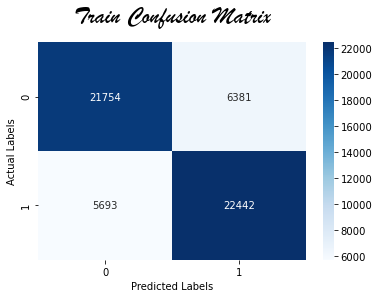

In [36]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred1, best_t)), annot = True, ax = ax, fmt = 'd', 
            cmap = "Blues")

ax.set_xlabel('Predicted Labels');
ax.set_ylabel('Actual Labels');
ax.set_title('Train Confusion Matrix', fontname ="Brush Script MT", fontsize = 25, pad = 20);

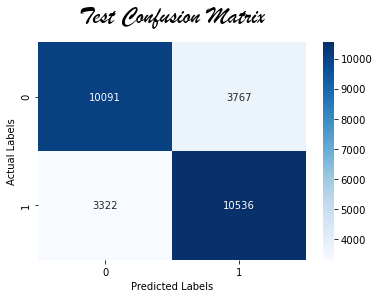

In [37]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred1, best_t)), annot = True, ax = ax, fmt = 'd', 
            cmap = "Blues")

ax.set_xlabel('Predicted Labels');
ax.set_ylabel('Actual Labels');
ax.set_title('Test Confusion Matrix', fontname ="Brush Script MT", fontsize = 25, pad = 20);

#### For `feature set 2`

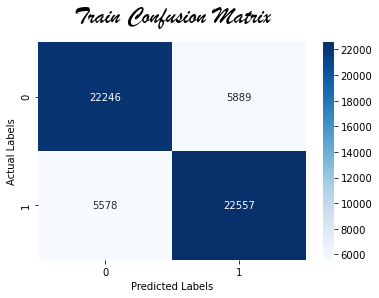

In [38]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred2, best_t)), annot = True, ax = ax, fmt = 'd', 
            cmap = "Blues")

ax.set_xlabel('Predicted Labels');
ax.set_ylabel('Actual Labels');
ax.set_title('Train Confusion Matrix', fontname ="Brush Script MT", fontsize = 25, pad = 20);

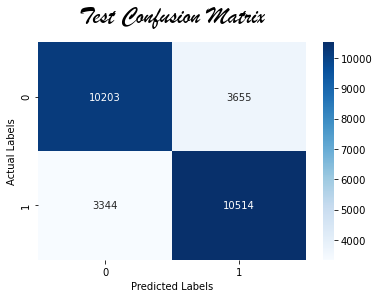

In [39]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred2, best_t)), annot = True, ax = ax, fmt = 'd', 
            cmap = "Blues")

ax.set_xlabel('Predicted Labels');
ax.set_ylabel('Actual Labels');
ax.set_title('Test Confusion Matrix', fontname ="Brush Script MT", fontsize = 25, pad = 20);

### 1.8 TOP 20 FEATURES from `Set 1`

In [40]:
import numpy as np
features = []
features.extend(essay_bow_features)
features.extend(school_state_features)
features.extend(teacher_prefix_features)
features.extend(project_grade_category_features)
features.extend(clean_categories_features)
features.extend(clean_subcategories_features)
features.append('price')
features.append('teacher_number_of_previously_posted_projects')

print("Total # of features:", len(features))

print()

positive = np.argsort((clf_set1.feature_log_prob_)[1])[:20]
top_20_positive_features = np.take(features, positive)
print("Positive features: ", top_20_positive_features)

print()

negative = np.argsort((clf_set1.feature_log_prob_)[0])[:20]
top_20_negative_features = np.take(features, negative)
print("Negative features: ", top_20_negative_features)

Total # of features: 50101

Positive features:  ['love use hands learning' 'this first full' 'first full year teach'
 'year teach kindergarten we' 'not dare' 'full year teach kindergarten'
 'this first full year' 'experiences make difference students'
 'experiences make difference' 'they love use hands'
 'teach kindergarten we' 'washington high' 'full year teach'
 'washington high school' 'important area' 'nasp' 'care_hunger' 'warmth'
 'materials experiences make' 'care_hunger']

Negative features:  ['scooter' 'stools wobble' 'risers' 'bee bots' 'use document camera'
 'dell chromebook' '60 minute' 'volleyballs' 'clorox wipes'
 'learning throughout day' 'these stools allow students' 'wobble cushion'
 'tile floor' 'planks' 'usb' 'chairs give students' 'wobble stools allow'
 'pete cat' 'wobble chairs students' 'pete']


### 1.9 Summary

In [41]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
x.add_row(["BoW", "Naive Bayes", best_alpha_set1.alpha, auc_set1])
x.add_row(["TFIDF", "Naive Bayes", best_alpha_set2.alpha, auc_set2])
print(x)

+------------+-------------+----------------+--------------------+
| Vectorizer |    Model    | Hyperparameter |        AUC         |
+------------+-------------+----------------+--------------------+
|    BoW     | Naive Bayes |       1        |  0.81135354365676  |
|   TFIDF    | Naive Bayes |       0        | 0.8211846416744014 |
+------------+-------------+----------------+--------------------+
